In [11]:
import math

import placement_model
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import util
from scipy.stats import lognorm
from util import coordinator_label, worker_label, cmarker
import networkx as nx
import placement_model as pm
from placement_model import OptimalPlacer
import timeit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Slot config

Std:  48.086220362594524


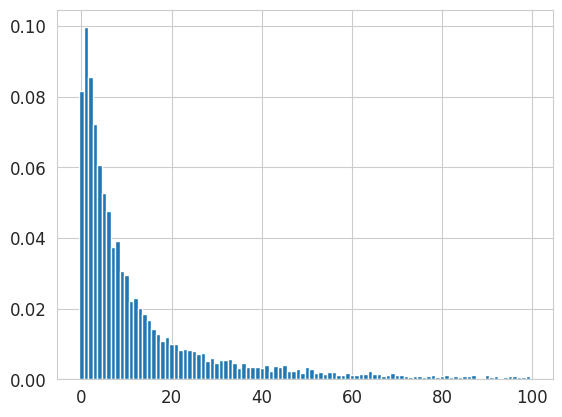

In [12]:
mode = 1
stddev = 50
sigma, scale = util.lognorm_params(mode, stddev)
sample = lognorm.rvs(sigma, 0, scale, size=10000).astype(int)

print("Std: ", np.std(sample))

H, bins = np.histogram(sample, bins=100, range=[0, 100], density=True)
plt.bar(bins[:-1],H,width=1)
plt.show()

#### Topology config

In [13]:
device_number = 100 + 1  #first node is the coordinator
types = ["coordinator", "worker", "worker"]
types_dist = [types[1], types[2], types[2], types[2], types[2]]
X_dim_range = [0, 100]
Y_dim_range = [-50, 50]

X_dim = [-10, 110]
Y_dim = [-60, 60]
centers = 40

eval_matrix = {}

#### Setup

In [14]:
coordinator_slots = 5
slot_columns = []
np.random.seed(4)
avg = 3
max_resources = device_number*avg - coordinator_slots
type_list = [types_dist[rd.randint(0, len(types_dist))] for x in range(device_number - 1)]
type_list.insert(0, types[0])

#X = rd.randint(low=X_dim[0], high=X_dim[1], size=(device_number,1))
#Y = rd.randint(low=Y_dim[0], high=Y_dim[1], size=(device_number,1))
#coords = np.column_stack((X,Y))

# blobs with varied variances
stds = np.random.uniform(low=0.5, high=5.3, size=(centers,))
coords, y = make_blobs(n_samples=device_number, centers=centers, n_features=2, shuffle=True,
                       cluster_std=stds,
                       center_box=[(X_dim_range[0], Y_dim_range[0]), (X_dim_range[1], Y_dim_range[1])], random_state=31)
c_coords = coords[0]

df = pd.DataFrame(coords, columns=["x", "y"])
df['latency'] = list(zip(df.x, df.y))
df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - c_coords))
df["type"] = pd.Series(type_list, dtype="category")

sums = []
for i in range(len(H), 0, -1):
    if (i % 10 == 0) or (i == 5) or (i == 1):
        #probabilites
        p = np.array(H[i-1:len(H)])
        p /= p.sum()  # normalize
        pop = np.arange(i-1, len(H))

        slot_list = np.random.choice(pop, device_number-1, p=p, replace=True)
        slot_list =np.insert(slot_list, 0, 0)

        col = "slots_"+str(i)
        df[col] = pd.Series(slot_list, dtype="int")
        df["slots_"+str(i)] = df[col] / df[col].sum() * max_resources

        df[col] = np.ceil(df[col]).astype("int")
        df.at[0, col] = coordinator_slots
        sums.append((df[col].sum()))
        slot_columns.append(col)

print(sums)
prim_df = df.copy()

[305, 354, 356, 354, 351, 360, 355, 350, 353, 351, 353, 357]


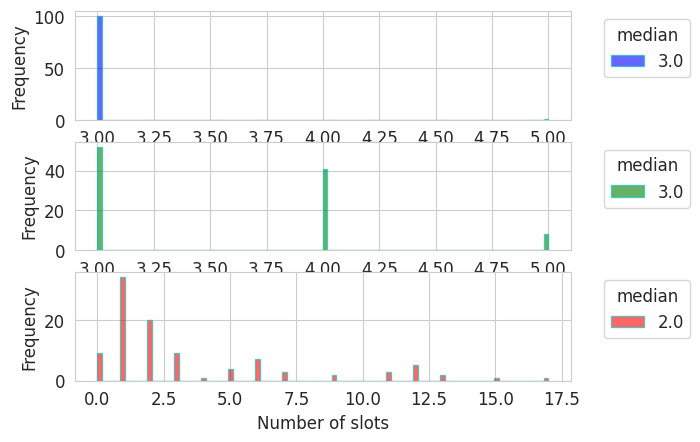

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

i=100
df["slots_"+str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c', label=df["slots_"+str(i)].median())

i=50
df["slots_"+str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c', label=df["slots_"+str(i)].median())

i=1
df["slots_"+str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c', label=df["slots_"+str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')

ax3.set_xlabel("Number of slots")

plt.show()

Medians from  0  to  0


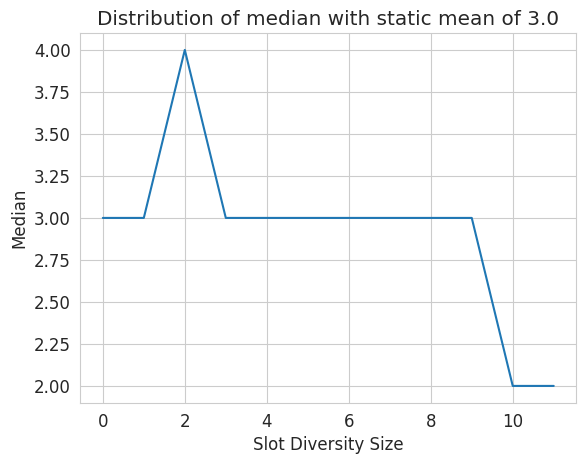

In [16]:
plt.show()
medians = []
mean = np.floor(prim_df["slots_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = str(int(medians[0] - medians[0] % 5))
last_med_label = str(int(medians[-1] - medians[-1] % 5))
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

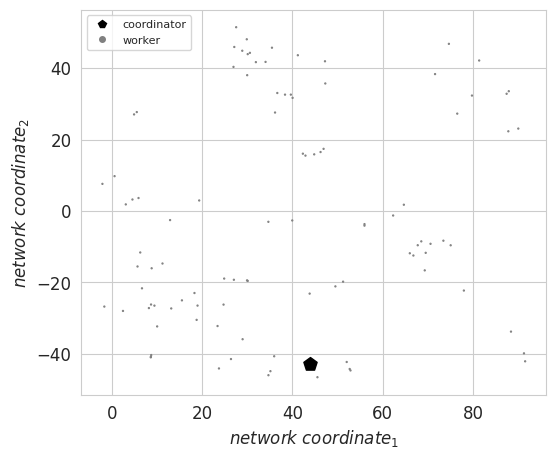

In [17]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

tcolors = {"coordinator": "red", "worker": "grey"}
scat2 = df.plot.scatter(ax=ax1, x="x", y="y", c=df["type"].map(tcolors), s=df["slots_" + str(100)]*0.15)

#plot coordinators
ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
#ax1.set_title('NES Topology in a Cost Space')
#plt.savefig("plots/topology.svg", bbox_inches = "tight")
plt.show()

In [18]:
df

,x,y,latency,type,slots_100,slots_90,slots_80,slots_70,slots_60,slots_50,slots_40,slots_30,slots_20,slots_10,slots_5,slots_1
0,43.824092,-42.944638,0.000000,coordinator,5,5,5,5,5,5,5,5,5,5,5,5
1,68.509634,-8.541695,42.343105,worker,3,4,4,3,3,3,3,3,2,2,4,2
2,5.713418,-15.582155,46.916191,worker,3,4,3,3,4,4,3,3,3,5,1,2
3,87.392514,32.825037,87.402809,worker,3,3,3,4,3,4,3,5,3,2,2,0
4,27.544792,51.474391,95.812153,worker,3,3,3,3,4,3,4,3,2,2,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,52.840600,-44.719086,9.189455,worker,3,3,3,4,3,3,4,5,2,4,3,6
97,12.918798,-2.584534,50.833800,worker,3,3,4,4,3,3,4,2,5,1,1,1
98,4.950405,27.036350,80.053121,worker,3,3,3,4,3,4,4,3,2,2,3,12
99,29.981937,38.028844,82.148098,worker,3,3,4,3,4,3,4,2,6,2,7,1


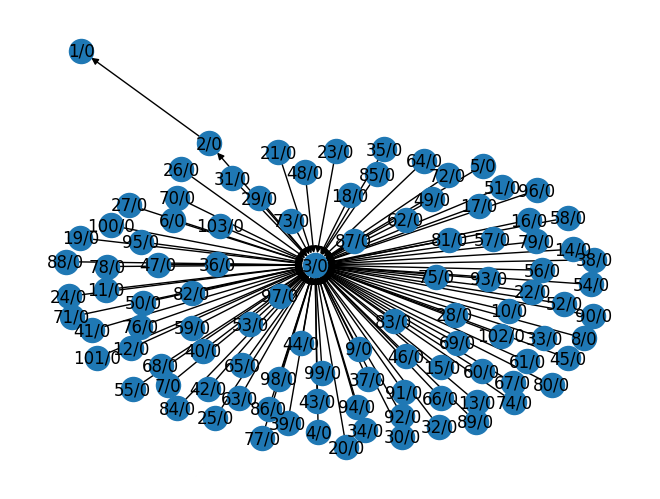

In [19]:
gg = pm.create_window_merging_example(len(df.index), 2)
g = gg.create_nx_graph()
nx.draw(g, with_labels=True, pos=nx.spring_layout(g))

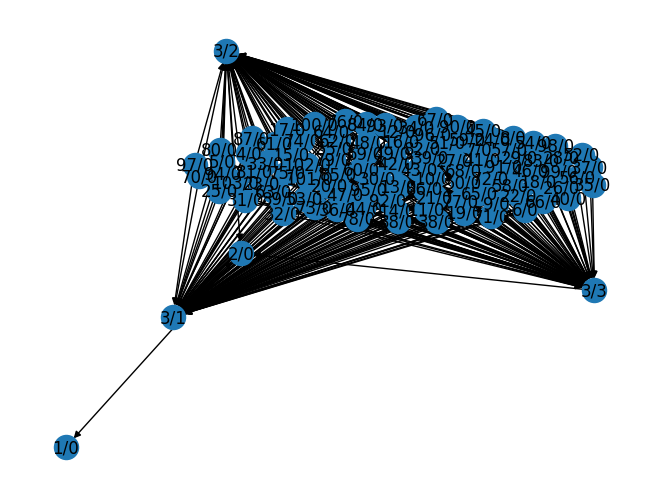

In [20]:
gg = pm.create_window_merging_example(len(df.index), 3)
gg.replicate()
g = gg.create_nx_graph()
nx.draw(g, with_labels=True, pos=nx.spring_layout(g))

In [21]:
placer = OptimalPlacer(df, gg)

In [52]:
start_time = timeit.default_timer()

In [53]:
plcmt, paths, cost = placer.get_best_mapping(with_constraints=True)

KeyboardInterrupt: 

In [54]:
elapsed = timeit.default_timer() - start_time
print("Elapsed time (s): ", elapsed)

Elapsed time (s):  975.438768082


In [22]:
print(plcmt)
print(paths)
print(cost)

((2/0, 0), (3/1, 0), (3/2, 2), (3/3, 4))
([4/0, 3/2, 2/0, 1/0], [5/0, 3/2, 2/0, 1/0], [6/0, 3/1, 2/0, 1/0], [7/0, 3/3, 2/0, 1/0], [8/0, 3/3, 2/0, 1/0])
460.21897727586395


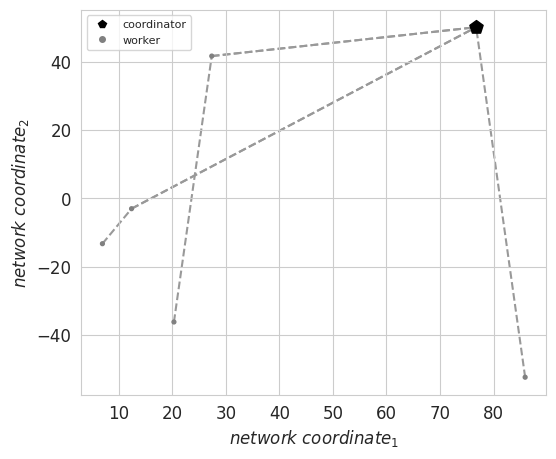

In [27]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

ax1 = pm.plot(ax1, df, paths, plcmt)

#ax1.set_title('NES Topology in a Cost Space')
#plt.savefig("plots/topology.svg", bbox_inches = "tight")
plt.show()